# Importing Libraries

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Importing pytorch functions and modules
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,mean_squared_error,accuracy_score
from xgboost import XGBClassifier,XGBRegressor


from memory_embeddings import EmbeddingNNModel
#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Tesla P100-PCIE-16GB


In [3]:
input_data = "task1_processed_data.csv"
total_data = pd.read_csv(input_data)
total_data.head()

,business_id,divey_False,trendy_False,casual_False,casual_True,garage_False,street_False,lot_False,lot_True,NoiseLevel_NA,NoiseLevel_average,BusinessAcceptsCreditCards_NA,RestaurantsDelivery_False,Alcohol_full_bar,Alcohol_none,WiFi_NA,WiFi_free,WiFi_no,RestaurantsReservations_False,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,GoodForKids_True,HasTV_False,HasTV_True,OutdoorSeating_False,OutdoorSeating_True,Caters_False,Caters_NA,Caters_True,dessert_False,lunch_False,lunch_True,dinner_False,dinner_True,BikeParking_NA,BikeParking_True,RestaurantsTableService_NA,RestaurantsTableService_True,review_id,business_legacy_stars_mean,business_legacy_funny,business_legacy_cool,business_legacy_useful,user_id,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,yelping_since_td,user_legacy_stars_mean,user_legacy_funny,user_legacy_cool,user_legacy_useful,stars_review
0,eU_713ec6fTGNO4BegRaww,1,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,S1aROCxDQMyG_EYgpB-CAA,0.672935,0.000000,0.000000,0.000000,UtkjXTiMfGRz4R1zDF3Kxg,0.878213,0.874866,0.975061,0.969967,0.999771,0.859553,0.853539,0.841861,0.841861,0.830966,0.625867,0.207319,0.592872,0.325596,0.578379,0.484170,5
1,eU_713ec6fTGNO4BegRaww,1,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,0TDA4X4HK9PjZSz4TM5n5A,0.849047,0.099229,0.157775,0.113951,PuPWzbQJ6P_tax-holDgSQ,0.236881,0.358604,0.602501,0.000000,0.000000,0.549206,0.476710,0.181533,0.181533,0.210555,0.000000,0.322367,0.679776,0.000000,0.000000,0.000000,5
2,eU_713ec6fTGNO4BegRaww,1,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,M0Y9h_qdU_LF5_TkltRkJQ,0.907751,0.099229,0.157775,0.140668,fEo1C7GJlK8HlfRfNouLbw,0.000000,0.000000,0.768287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.210555,0.000000,0.331516,0.632618,0.000000,0.000000,0.172937,5
3,eU_713ec6fTGNO4BegRaww,1,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,D2oYk9ipsvsYP_ls0aL9kg,0.937103,0.099229,0.157775,0.161335,9IA3P3DxrZcoAl29IYOloA,0.236881,0.645229,0.602501,0.000000,0.000000,0.191458,0.521292,0.478216,0.478216,0.379649,0.000000,0.314580,0.813156,0.000000,0.000000,0.397308,4
4,eU_713ec6fTGNO4BegRaww,1,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,4yLl21v8cJEgJSjYCKoV5Q,0.897848,0.099229,0.184420,0.161335,7MI0oX7_fTwjU5NML80jsw,0.000000,0.506017,0.000000,0.000000,0.000000,0.502679,0.180652,0.436429,0.436429,0.426655,0.571068,0.364804,0.813156,0.000000,0.000000,0.397308,5


In [0]:
features = [col for col in total_data.columns if col not in ["review_id","business_id","user_id","stars_review"]]

In [0]:
def nearest_integer(x):
  x = max(0,x)
  x = min(x,4)
  x_int = int(x)
  if(x-x_int>=0.5):
    return(x_int+1)
  else:
    return(x_int)



class myDataset(Dataset):


    def __init__(self, images,labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return(self.images.shape[0]) 

    def __getitem__(self, idx):
        # return the augmented image
        assert(idx<self.images.shape[0])
        return (torch.tensor(self.images[idx,:],dtype=torch.float64),torch.tensor(self.labels.reshape(-1)[idx]))

# Defining neural network and training classes

In [0]:
class Neural_Network(nn.Module):
    def __init__(self,input_dm,output_dm,a=-2,dropout=0):
        super(Neural_Network,self).__init__()
        self.input_layer = nn.Linear(input_dm, 64)
        self.hidden_layer_1 = nn.Linear(64, 32)
        self.hidden_layer_2 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16,output_dm)
        self.act = torch.nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=input_dm,affine=False,track_running_stats=False)
        self.bn2 = nn.BatchNorm1d(num_features=input_dm,affine=False,track_running_stats=False)
        self.dd = nn.Dropout(dropout)
#         print("Neural network defined for device: "+str(device))
#         print("Input image shape: ["+str(input_dm1)+","+str(input_dm2)+"]")
        
        
    def forward(self, x):
        
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.dd(x)
        
        #hidden layers
        x = self.hidden_layer_1(x)
        x = self.act(x)
        x = self.bn1(x)
        x = self.dd(x)
        x = self.hidden_layer_2(x)
        x = self.act(x)
        x = self.bn2(x)
        x = self.dd(x)
        x = self.output_layer(x)
        x = self.dd(x)
        
        return(x)

In [0]:
class train_neural_network:

    def __init__(self,Model_Class,batch_size,total_data,features,target,
                 stratify_var,user_embedding_size,business_embedding_size,device,use_saved_loaders):
        
        
        super(train_neural_network,self).__init__()

        labels = total_data[target].values - 1
        if(use_saved_loaders==True):
          try:
            self.train_loader = torch.load("temp_train_loader.pt")
            self.val_loader = torch.load("temp_val_loader.pt")
            self.n_train = np.sum(np.array([x.shape[0] for x,y in self.train_loader]))
            self.n_val = np.sum(np.array([x.shape[0] for x,y in self.val_loader]))
          except:
            print("Data loaders not found, creating instead")
            use_saved_loaders=False
        if(use_saved_loaders==False):
          emb = EmbeddingNNModel(total_data,user_embedding_size,business_embedding_size,"model2")
          self.batch_size = batch_size

          self.train_df,self.val_df,_,_ = train_test_split(total_data,total_data[target].values,
                                                stratify=total_data[stratify_var].values,
                                                        shuffle=True,random_state=SEED)
          emb.model_training(self.train_df,SEED)
          
          x_train_u = emb.get_user_embeddings(self.train_df["user_id"].values)
          x_train_b = emb.get_business_embeddings(self.train_df["business_id"].values)
          self.x_train = np.concatenate((self.train_df[features].values,x_train_u,x_train_b),axis=1)
          self.n_train = self.x_train.shape[0]
          self.y_train = self.train_df[target].values - 1 
          
          x_val_u = emb.get_user_embeddings(self.val_df["user_id"].values)
          x_val_b = emb.get_business_embeddings(self.val_df["business_id"].values)
          self.x_val = np.concatenate((self.val_df[features].values,x_val_u,x_val_b),axis=1)
          self.n_val = self.x_val.shape[0]
          self.y_val = self.val_df[target].values - 1 
          self.n_val = self.x_val.shape[0]
          
          train_dataset = myDataset(self.x_train,self.y_train)
          val_dataset = myDataset(self.x_val,self.y_val)
          
          
          weights_train = self.make_weights_for_balanced_classes(labels,self.y_train)
          weights_train = torch.DoubleTensor(weights_train)
          sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights_train, len(weights_train))
          self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size,shuffle=True)                              
                                                      #sampler = sampler_train, num_workers=0)
          
          weights_val = self.make_weights_for_balanced_classes(labels,self.y_val)
          weights_val = torch.DoubleTensor(weights_val)
          sampler_val = torch.utils.data.sampler.WeightedRandomSampler(weights_val, len(weights_val))
          self.val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(self.y_val),shuffle=True)                             
                                                      #sampler = sampler_val, num_workers=0)
          torch.save(self.train_loader,"temp_train_loader.pt")
          torch.save(self.val_loader,"temp_val_loader.pt")
        
        x_sample,y_sample = next(iter(self.train_loader))
        self.input_dm = x_sample.shape[1]
        self.cw = self.make_class_weights(labels)
        self.Model_Class = Model_Class
        
        
        
        
    def train(self,max_epochs,verbose,learning_rate,class_weight,dropout=0):
        self.dropout = dropout
        self.model = self.Model_Class(input_dm = self.input_dm,
                                    output_dm = 5,
                                    dropout=self.dropout).to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        if(class_weight=="uniform"):
          cw = torch.ones((5))
        else:
          cw = self.cw
        criterion = torch.nn.CrossEntropyLoss(weight=cw).to(device)

        self.train_loss_history = []
        self.val_loss_history = []
        self.best_loss = np.inf
        
        epoch = 0
        rounds = 0
        early_stopping_rounds = 5
        stop = False
        

        while ((epoch < max_epochs)&(stop==False)):

            total_loss = 0.0
            for x,y in self.train_loader:
                y = torch.tensor(y).to(device)
                x = x.float().to(device)
                y_pred_hat = F.softmax(self.model.forward(x),dim=1)

                batch_ce_loss = criterion(y_pred_hat,y)

                optimizer.zero_grad()
                batch_ce_loss.backward()
                optimizer.step()
                total_loss = total_loss + batch_ce_loss.item()*x.shape[0]
            train_loss = total_loss/self.n_train
            self.train_loss_history.append(train_loss)

            total_loss = 0.0
            x_val,y_val =  next(iter(self.val_loader))
            y_val = torch.tensor(y_val).to(device)
            x_val = x_val.float().to(device)
            y_pred_hat = F.softmax(self.model.forward(x_val),dim=1)
            y_pred = torch.argmax(y_pred_hat,1)
            f1 = f1_score(y_val.cpu(),y_pred.cpu(),average="micro")
            acc = accuracy_score(y_val.cpu(),y_pred.cpu())
            mse = mean_squared_error(y_val.cpu(),y_pred.cpu())
            val_loss = round(criterion(y_pred_hat,y_val).item(),2)

            self.val_loss_history.append(val_loss)


            if(val_loss<self.best_loss):
                self.best_loss = val_loss
                rounds = 0
            else:
                rounds += 1


            if(rounds>=early_stopping_rounds):
                stop=True
                
            
            if((verbose==True)&((epoch%5==0)|(stop==True))):
                print("----------------------------------------------------------------------------------")
                print("EPOCH:"+str(epoch))
                if(stop==True):
                    print("Training to be concluded after this epoch") 
                print("Average training loss  = "+str(train_loss))
                print("Average Validation loss  = "+str(val_loss))
                print("Micro F1 Score  = "+str(f1))
                #print("Accuracy  = "+str(acc))
                print("MSE Score  = "+str(mse))



            epoch += 1
        #While loop ends
                        
        self.model_state = self.model.state_dict()
        
        self.plot_loss()       

    def train_for_mse(self,max_epochs,verbose,learning_rate,dropout):
        
        self.dropout=dropout
        self.model = self.Model_Class(input_dm = self.input_dm,
                                    output_dm = 1,
                                    dropout=self.dropout).to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        criterion = torch.nn.MSELoss().to(device)
        ht = torch.nn.Hardtanh(min_val=0.0, max_val=4.0)

        self.train_loss_history = []
        self.val_loss_history = []
        self.best_loss = np.inf
        
        epoch = 0
        rounds = 0
        early_stopping_rounds = 5
        stop = False
        

        while ((epoch < max_epochs)&(stop==False)):

            total_loss = 0.0
            for x,y in self.train_loader:
                y = torch.tensor(y,dtype=torch.float,requires_grad=True).to(device)
                x = x.float().to(device)
                y_pred = torch.tensor(self.model.forward(x),requires_grad=True,dtype=torch.float).to(device).reshape(-1)
                y_pred = 4*F.sigmoid(y_pred)
                batch_mse_loss = criterion(y_pred,y)

                optimizer.zero_grad()
                batch_mse_loss.backward()
                optimizer.step()
                total_loss = total_loss + batch_ce_loss.item()*x.shape[0]
            train_loss = total_loss/self.n_train
            self.train_loss_history.append(train_loss)

            total_loss = 0.0
            x_val,y_val =  next(iter(self.val_loader))
            y_val = torch.tensor(y_val,dtype=torch.float,requires_grad=False).to(device)
            x_val = x_val.float().to(device)
            y_pred = torch.tensor(self.model.forward(x_val),requires_grad=False,dtype=torch.float).to(device).reshape(-1)
            y_pred = 4*F.sigmoid(y_pred)
            
            
            mse = mean_squared_error(y_val.cpu(),y_pred.cpu())
            val_loss = round(criterion(y_pred,y_val).item(),2)
            ne = np.vectorize(nearest_integer)
            y_pred_int = ne(y_pred.detach().cpu().numpy())
            y_val_int = y_val.cpu().numpy()
            f1 = f1_score(y_val_int,y_pred_int,average="micro")
            acc = accuracy_score(y_val_int,y_pred_int)


            self.val_loss_history.append(val_loss)


            if(val_loss<self.best_loss):
                self.best_loss = val_loss
                rounds = 0
            else:
                rounds += 1


            if(rounds>=early_stopping_rounds):
                stop=True
                
            
            if((verbose==True)&((epoch%5==0)|(stop==True))):
                print("----------------------------------------------------------------------------------")
                print("EPOCH:"+str(epoch))
                if(stop==True):
                    print("Training to be concluded after this epoch") 
                print("Average training loss  = "+str(train_loss))
                print("Average Validation loss  = "+str(val_loss))
                print("MSE Score  = "+str(mse))
                print("Micro F1 Score  = "+str(f1))



            epoch += 1
        #While loop ends
                        
        self.model_state = self.model.state_dict()
        
        self.plot_loss()       
            
        
    def plot_loss(self):
        print("----------------------------------------------------------------------------------")
        plt.plot(self.train_loss_history)
        plt.plot(self.val_loss_history)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
    def make_weights_for_balanced_classes(self,labels_total,labels_curr):
        classes,counts = np.unique(labels_total,return_counts=True)
        counts = np.divide(np.sum(counts),counts)      
        class_weights = dict(zip(classes,counts))
        weights = np.apply_along_axis(lambda x:class_weights[x[0]],1,labels_curr.reshape(-1,1))
        weights_sum = np.sum(weights)
        weights = weights / (weights_sum/len(weights))
        return(weights)

    def make_class_weights(self,labels):
        cw = np.zeros((len(np.unique(labels))))
        for i in range(0,len(cw)):
          cw[i] = np.sum(labels==i)
        cw = np.divide(len(labels),cw)
        return(torch.tensor(cw,dtype=torch.float))
                                      
    #def predict()

# Training the neural network

In [0]:
tr = train_neural_network(Model_Class=Neural_Network,
                          batch_size=5000,
                          total_data=total_data,
                          features=[],
                          target="stars_review",
                          stratify_var="user_id",
                          user_embedding_size=40,
                          business_embedding_size=40,
                          device=device,
                          use_saved_loaders=True)

In [0]:
tr.train(max_epochs=200,verbose=True,learning_rate=0.0005,dropout=0,class_weight='uniform')

----------------------------------------------------------------------------------
EPOCH:0
Average training loss  = 1.4332624028002472
Average Validation loss  = 1.41
MSE Score  = 1.4149091
Micro F1 Score  = 0.34230223570275425
----------------------------------------------------------------------------------
EPOCH:5
Training to be concluded after this epoch
Average training loss  = 1.4332624328227226
Average Validation loss  = 1.41
MSE Score  = 1.4149091
Micro F1 Score  = 0.34230223570275425
----------------------------------------------------------------------------------


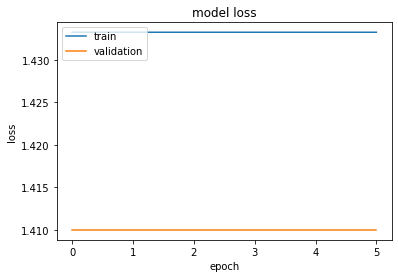

In [87]:
#tr.train_for_mse(max_epochs=200,verbose=True,learning_rate=0.0001,dropout=0)

# Trying LightGBM cause why not

In [9]:
!pip install lightgbm
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=d485fefdab767a9de2583926a99b5f4c82748a7c3494705660e6a00fdf34d455
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
# x_train = tr.train_df[features].values
# y_train = tr.train_df["stars_review"].values
# x_val = tr.val_df[features].values
# y_val = tr.val_df["stars_review"].values

x_train = tr.x_train
x_val = tr.x_val
y_train = tr.y_train
y_val = tr.y_val

In [0]:
from lightgbm import LGBMClassifier,LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import *
import time

In [0]:
def bayes_opt_f1(x_train,y_train,x_val,y_val, init_round=15, opt_round=15, random_seed=SEED):
    t1 = time.time()
    

        
    def lgb_eval(learning_rate,n_estimators,max_depth,min_child_weight,gamma,subsample,colsample_bytree,reg_alpha):
        
        lgc = LGBMClassifier(learning_rate=learning_rate,n_estimators=int(n_estimators)
                            ,max_depth=int(max_depth),min_child_weight=min_child_weight,
                             gamma=gamma,subsample=subsample,colsample_bytree=colsample_bytree,
                             reg_aplha=reg_alpha)
        lgc.fit(x_train,y_train)
        y_val_pred = lgc.predict(x_val)
        return(f1_score(y_val,y_val_pred,average='micro'))
        
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01,0.2),
                                            'n_estimators': (10,100),
                                            'max_depth': (5, 8.99),
                                            'min_child_weight': (5, 50),
                                            'gamma':(0,0.5),
                                            'subsample': (0.4, 1.0),
                                            'colsample_bytree' :(0.4, 1.0),
                                            'reg_alpha':(0.001,100)
                                            }, 
                                               random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    

    
    # return best parameters
    targets = np.array([d['target'] for d in lgbBO.res])
    opt_params = lgbBO.res[np.argmax(targets)]['params']
    opt_params['max_depth'] = int(opt_params['max_depth'])
    opt_params['n_estimators'] = int(opt_params['n_estimators'])
    lgc = LGBMClassifier(**opt_params)
    print("Time taken for hyper-parameter optimization:" + str(time.time()-t1) )
    return(lgc)

In [50]:
lgc = bayes_opt_f1(x_train,y_train,x_val,y_val, init_round=10, opt_round=10, random_seed=SEED)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.4222   |  0.7293   |  0.3576   |  0.1245   |  7.174    |  24.06    |  68.13    |  43.76    |  0.9351   |
|  2        |  0.4214   |  0.9782   |  0.1917   |  0.1604   |  7.11     |  30.56    |  93.3     |  7.105    |  0.4523   |
|  3        |  0.423    |  0.4121   |  0.4163   |  0.1578   |  8.471    |  49.04    |  81.92    |  46.15    |  0.8683   |
|  4        |  0.4168   |  0.471    |  0.32     |  0.03724  |  8.769    |  28.48    |  47.32    |  26.46    |  0.8645   |
|  5        |  0.4132   |  0.6737   |  0.2842   |  0.01357  |  7.464    |  32.54    |  65.52    |  94.37    |  0.8091   |
|  6        |  0.423    |  0.6157   |  0.2185   |  0.1425   |  5.24     |  35.0     |  70.36    |  21.04    |  0.4774   |
|  7        |  0.4193   

In [51]:
lgc.fit(x_train,y_train)
y_val_pred = lgc.predict(x_val)
print("F1 Score(micro):",f1_score(y_val,y_val_pred,average='macro'))
print("F1 Score(macro):",f1_score(y_val,y_val_pred,average='micro'))
print("Accuracy:",accuracy_score(y_val,y_val_pred))
print("Mean Squared Error:",mean_squared_error(y_val,y_val_pred))

F1 Score(micro): 0.28717156902067487
F1 Score(macro): 0.42390294016926766
Accuracy: 0.42390294016926766
Mean Squared Error: 1.7868254977740814


In [0]:
def bayes_opt_mse(x_train,y_train,x_val,y_val, init_round=15, opt_round=15, random_seed=SEED):
    t1 = time.time()
    

        
    def lgb_eval(learning_rate,n_estimators,max_depth,min_child_weight,gamma,subsample,colsample_bytree,reg_alpha):
        
        lgr = LGBMRegressor(learning_rate=learning_rate,n_estimators=int(n_estimators)
                            ,max_depth=int(max_depth),min_child_weight=min_child_weight,
                             gamma=gamma,subsample=subsample,colsample_bytree=colsample_bytree,
                             reg_aplha=reg_alpha)
        lgr.fit(x_train,y_train)
        y_val_pred = lgr.predict(x_val)
        return((-1)*mean_squared_error(y_val,y_val_pred))
        
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01,0.2),
                                            'n_estimators': (10,100),
                                            'max_depth': (5, 8.99),
                                            'min_child_weight': (5, 50),
                                            'gamma':(0,0.5),
                                            'subsample': (0.4, 1.0),
                                            'colsample_bytree' :(0.4, 1.0),
                                            'reg_alpha':(0.001,100)
                                            }, 
                                               random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    

    
    # return best parameters
    targets = np.array([d['target'] for d in lgbBO.res])
    opt_params = lgbBO.res[np.argmax(targets)]['params']
    opt_params['max_depth'] = int(opt_params['max_depth'])
    opt_params['n_estimators'] = int(opt_params['n_estimators'])
    lgr = LGBMRegressor(**opt_params)
    print("Time taken for hyper-parameter optimization:" + str(time.time()-t1) )
    return(lgr)

In [53]:
lgr = bayes_opt_mse(x_train,y_train,x_val,y_val, init_round=10, opt_round=10, random_seed=SEED)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -1.223    |  0.7293   |  0.3576   |  0.1245   |  7.174    |  24.06    |  68.13    |  43.76    |  0.9351   |
|  2        | -1.226    |  0.9782   |  0.1917   |  0.1604   |  7.11     |  30.56    |  93.3     |  7.105    |  0.4523   |
|  3        | -1.224    |  0.4121   |  0.4163   |  0.1578   |  8.471    |  49.04    |  81.92    |  46.15    |  0.8683   |
|  4        | -1.231    |  0.471    |  0.32     |  0.03724  |  8.769    |  28.48    |  47.32    |  26.46    |  0.8645   |
|  5        | -1.25     |  0.6737   |  0.2842   |  0.01357  |  7.464    |  32.54    |  65.52    |  94.37    |  0.8091   |
|  6        | -1.223    |  0.6157   |  0.2185   |  0.1425   |  5.24     |  35.0     |  70.36    |  21.04    |  0.4774   |
|  7        | -1.225    

In [54]:
lgr.fit(x_train,y_train)
y_val_pred = lgc.predict(x_val)
print("Mean Squared Error:",mean_squared_error(y_val,y_val_pred))


Mean Squared Error: 1.7868254977740814


In [55]:
nv = np.vectorize(nearest_integer)
y_val_pred = nv(y_val_pred)
print("F1 Score(micro):",f1_score(y_val,y_val_pred,average='macro'))
print("F1 Score(macro):",f1_score(y_val,y_val_pred,average='micro'))
print("Accuracy:",accuracy_score(y_val,y_val_pred))

F1 Score(micro): 0.28717156902067487
F1 Score(macro): 0.42390294016926766
Accuracy: 0.42390294016926766
